In [291]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

SAMPLE_RATE = 16384
OVERLAP_FRACTION = 0.25
FRAME_LENGTH = 128
FRAME_STEP = int(FRAME_LENGTH * (1 - OVERLAP_FRACTION))
print(FRAME_STEP)
DATASET_PATH = "dataset"
data_dir = pathlib.Path(DATASET_PATH)

commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store') & (commands != 'LICENSE')]
print('Commands:', commands)



96
Commands: ['zero' 'not_zero']


In [292]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.25,
    seed=0,
    output_sequence_length=SAMPLE_RATE,
    subset='both',
    label_mode='binary')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)



Found 8741 files belonging to 2 classes.
Using 6556 files for training.
Using 2185 files for validation.

label names: ['not_zero' 'zero']


In [293]:
train_ds.element_spec

(TensorSpec(shape=(None, 16384, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

In [294]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

#Data contains single channel audio, last dimension of the tensor can be dropped
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
train_ds.element_spec

(TensorSpec(shape=(None, 16384), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))

In [295]:
#Split validation data set into validation and testing
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)


(64, 16384)
(64, 1)
['zero' 'zero' 'not_zero']


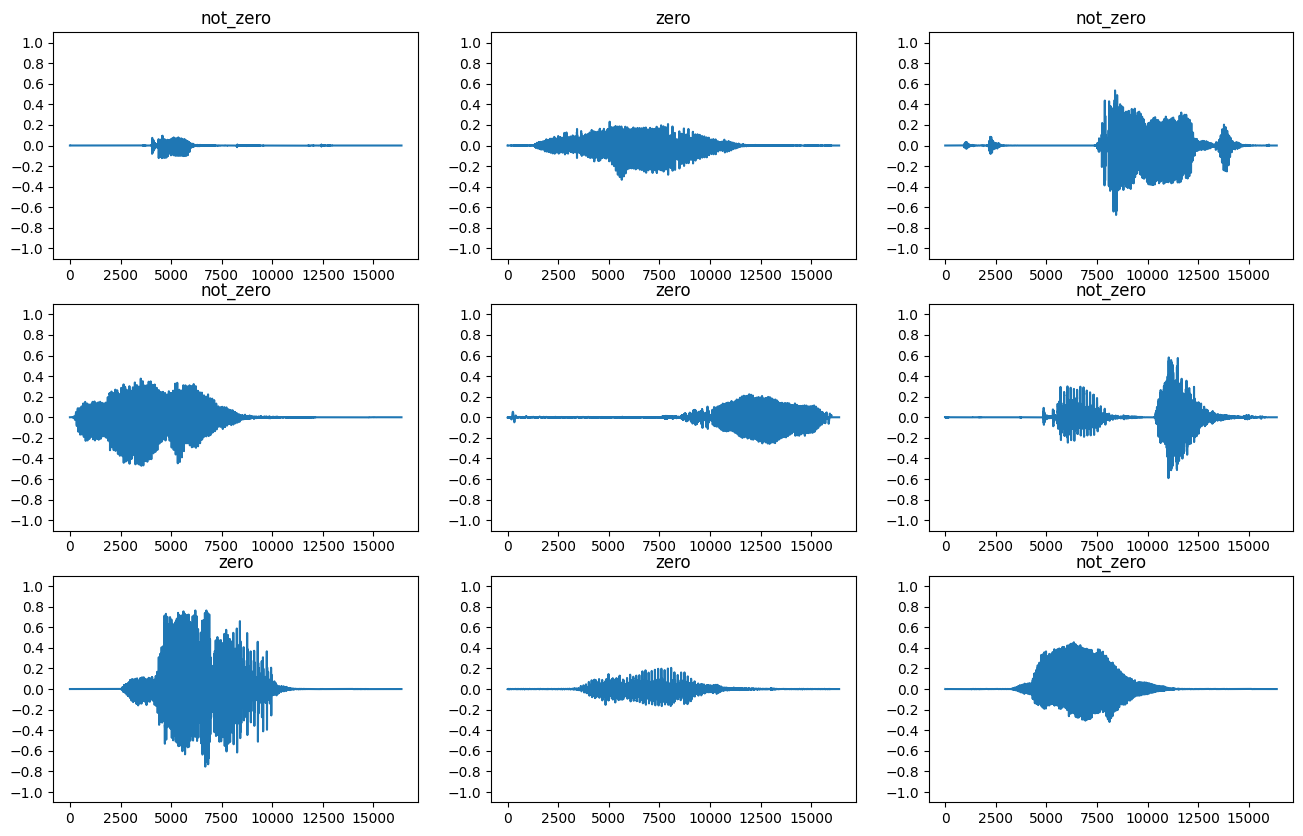

In [296]:

for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)


print(label_names[[1,1,0]])
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[int(example_labels[i])])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

In [297]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [298]:
for i in range(3):
  label = label_names[int(example_labels[i])]
  waveform = example_audio[i]

  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=SAMPLE_RATE))


Label: not_zero
Waveform shape: (16384,)
Spectrogram shape: (170, 65, 1)
Audio playback


Label: zero
Waveform shape: (16384,)
Spectrogram shape: (170, 65, 1)
Audio playback


Label: not_zero
Waveform shape: (16384,)
Spectrogram shape: (170, 65, 1)
Audio playback


In [299]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


170


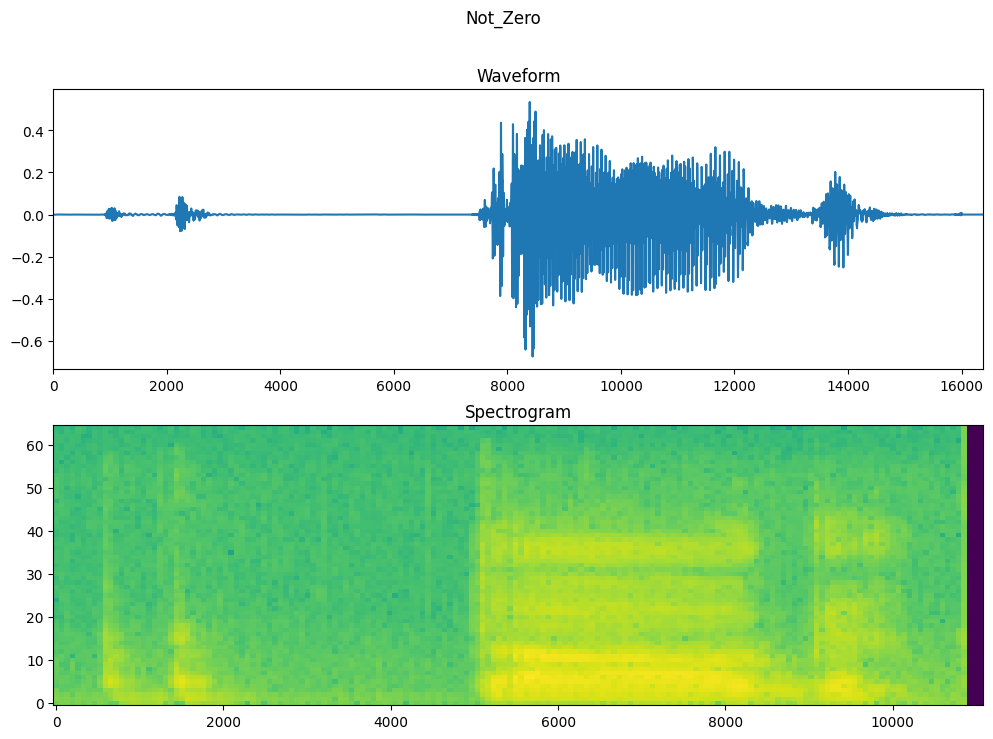

In [300]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, SAMPLE_RATE])

print(len(spectrogram.numpy()))
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()


In [301]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)
print(train_spectrogram_ds.element_spec)

(TensorSpec(shape=(None, 170, 65, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))


/tmp/ipykernel_5687/438975810.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title(label_names[int(example_spect_labels[i].numpy())])


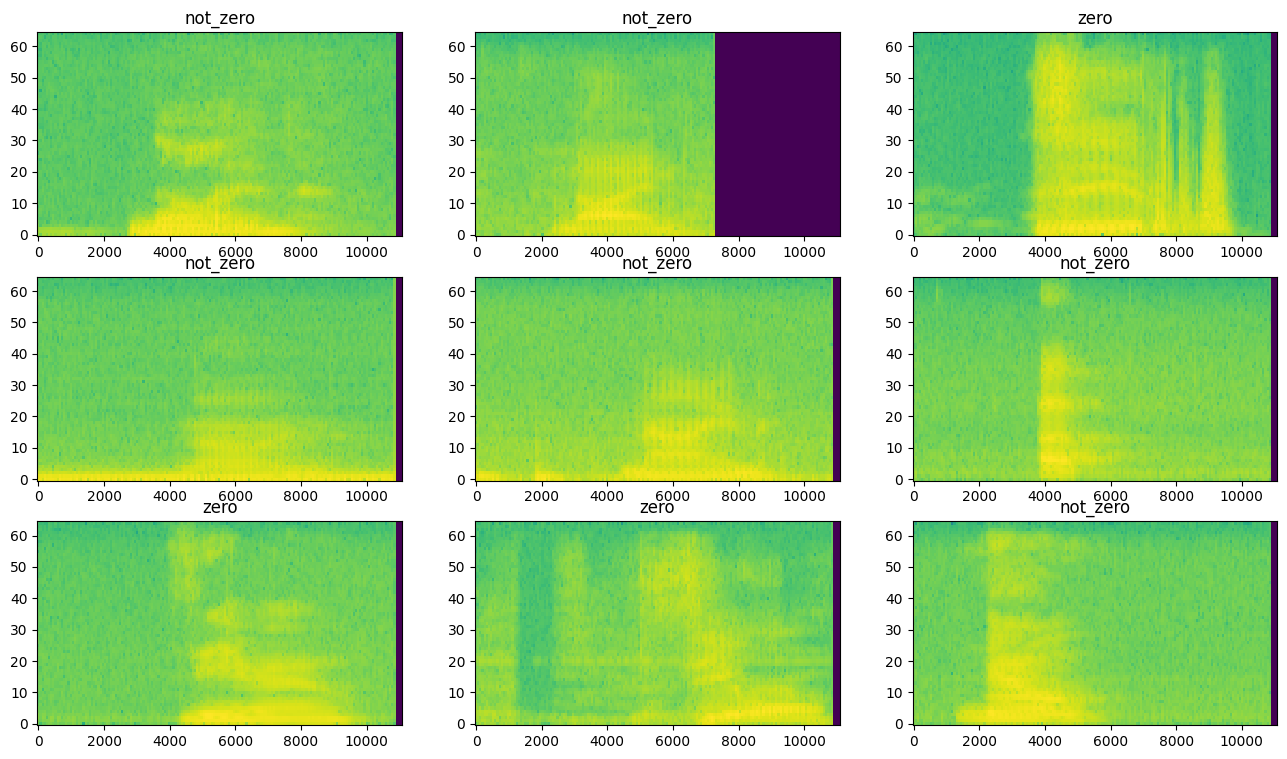

In [302]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[int(example_spect_labels[i].numpy())])

plt.show()


In [303]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = 2  # Two classes: 'zero' or 'not zero'

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax'),  # Output layer with softmax activation for binary classification
])

model.summary()


Input shape: (170, 65, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_6 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_6 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)       

In [304]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [305]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Epoch 1/10


/home/petru/.local/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


103/103 [==============================] - 2s 19ms/step - loss: 0.3289 - accuracy: 0.8642 - val_loss: 0.1992 - val_accuracy: 0.9393
Epoch 2/10
103/103 [==============================] - 2s 17ms/step - loss: 0.1661 - accuracy: 0.9410 - val_loss: 0.1420 - val_accuracy: 0.9540
Epoch 3/10
103/103 [==============================] - 2s 18ms/step - loss: 0.1245 - accuracy: 0.9556 - val_loss: 0.1182 - val_accuracy: 0.9651
Epoch 4/10
103/103 [==============================] - 2s 17ms/step - loss: 0.1129 - accuracy: 0.9602 - val_loss: 0.1116 - val_accuracy: 0.9678
Epoch 5/10
103/103 [==============================] - 2s 19ms/step - loss: 0.0846 - accuracy: 0.9687 - val_loss: 0.1058 - val_accuracy: 0.9706
Epoch 6/10
103/103 [==============================] - 2s 22ms/step - loss: 0.0730 - accuracy: 0.9724 - val_loss: 0.0927 - val_accuracy: 0.9743
Epoch 7/10
103/103 [==============================] - 2s 24ms/step - loss: 0.0683 - accuracy: 0.9741 - val_loss: 0.1034 - val_accuracy: 0.9724
Epoch 8/10

Text(0, 0.5, 'Accuracy [%]')

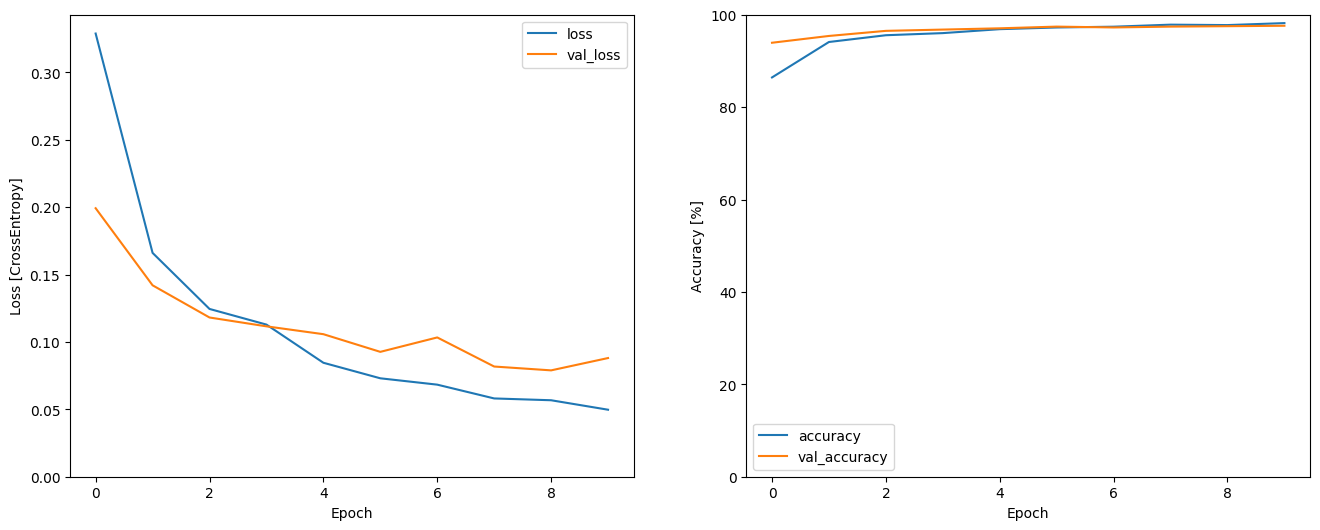

In [306]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')


In [307]:
model.evaluate(test_spectrogram_ds, return_dict=True)


18/18 [==============================] - 0s 7ms/step - loss: 0.1255 - accuracy: 0.9681


{'loss': 0.1255289614200592, 'accuracy': 0.9680948257446289}

In [308]:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)


18/18 [==============================] - 0s 5ms/step


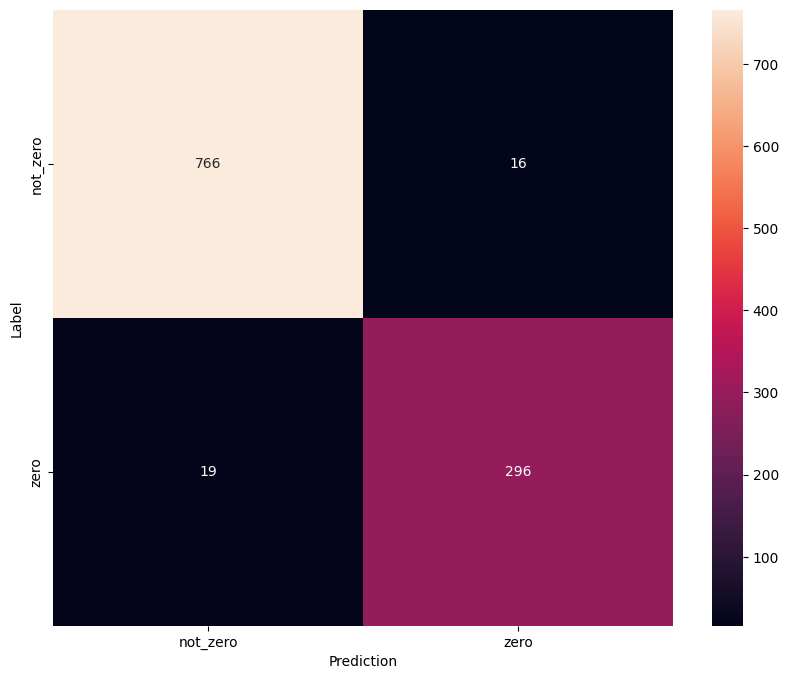

In [309]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()


In [310]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

for example_spectrogram, example_spect_labels in train_spectrogram_ds.take(1):
  break

print(example_spectrogram.shape)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_gen():
    for i in range(0, len(example_spectrogram), 100):
        # Get sample input data as a numpy array in a method of your choosing.
        yield [example_spectrogram.numpy()[i:i+100]]

converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


(64, 170, 65, 1)
INFO:tensorflow:Assets written to: /tmp/tmppqa174w3/assets


INFO:tensorflow:Assets written to: /tmp/tmppqa174w3/assets
/home/petru/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-01-05 21:17:35.392887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-05 21:17:35.392902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-01-05 21:17:35.392996: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmppqa174w3
2024-01-05 21:17:35.393713: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-01-05 21:17:35.393720: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmppqa174w3
2024-01-05 21:17:35.395831: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-01-05 21:17:35.428